In [35]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
%matplotlib inline

## Bring in the UNSODA data

The database was downloaded from:
https://www.ars.usda.gov/research/software/download/?modeCode=20-36-05-00&softwareid=106

Necessary data was exported from access data base to excell sheets and imported into Pandas

In [2]:
CondData = pd.read_excel('.\Data\lab_drying_h-k.xlsx') # in cm/d
ThetaData = pd.read_excel('.\Data\lab_drying_h-t.xlsx') # in cm3/cm3

## Join the data into a single data frame and have a quick look

In [3]:
MergedData = pd.merge(left=ThetaData, right=CondData,on=['code','preshead'])

In [4]:
Data = MergedData.dropna()

In [5]:
Data.set_index('code',inplace=True,drop=False)

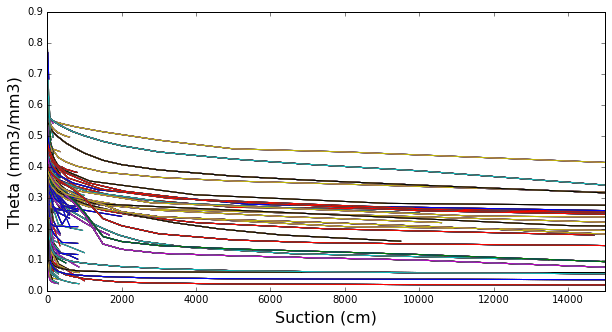

In [6]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],Data.ix[soil,'theta'])
plt.xlim(0,15000)
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)

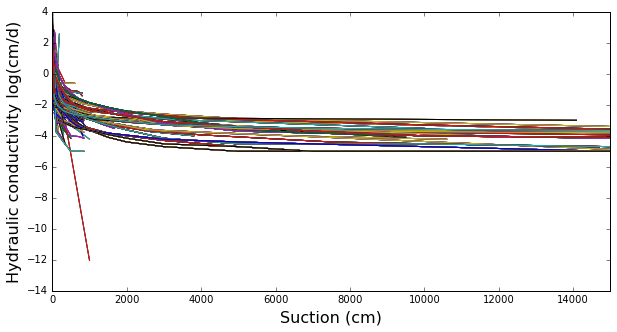

In [7]:
fig = plt.figure(figsize=(10,5))

for soil in Data.index:
    plt.plot(Data.ix[soil,'preshead'],np.log10(Data.ix[soil,'conductivity']))
plt.xlim(0,15000)
plt.ylabel('Hydraulic conductivity log(cm/d)',fontsize=16)
plt.xlabel('Suction (cm)',fontsize=16)


## Quite alot of soils have insufficient range in their k and theta measurements to be useful.  
## Filter out anything that has a narrow range of measurements

In [8]:
#This cell throws a copy slice error and takes a long time to run, but it still does what is intended.
Data.ix[:,'FullSet'] = 'false'
for soil in Data.index:
    if Data.ix[soil,'preshead'].max() >= 15000 and Data.ix[soil,'preshead'].min() <= 100:
        Data.ix[soil,'FullSet'] = 'true'

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
SetFilter = Data.ix[:,'FullSet'] == 'true'

In [10]:
FullData = Data.ix[SetFilter,:].copy()

### Convert conductivity data to mm/h and potentials to mmH2O

In [11]:
condcmd = FullData.ix[:,'conductivity']
prescm = FullData.ix[:,'preshead']
FullData.ix[:,'conductivity'] = condcmd*10/24
FullData.ix[:,'preshead'] = prescm * 10

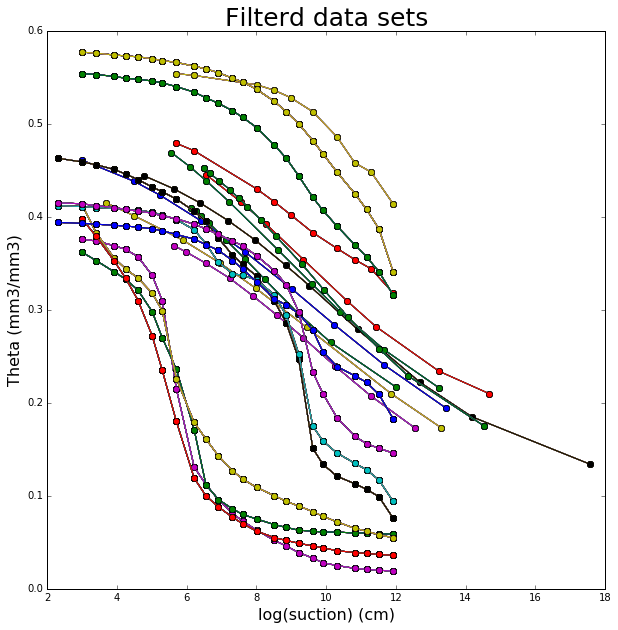

In [12]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(np.log(FullData.ix[soil,'preshead']),FullData.ix[soil,'theta'],'o-')
plt.ylabel('Theta (mm3/mm3)',fontsize=16)
plt.xlabel('log(suction) (cm)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)


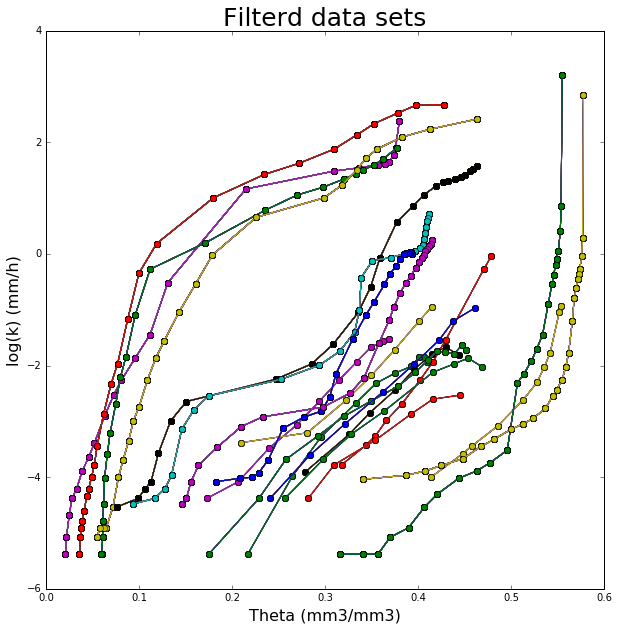

In [13]:
fig = plt.figure(figsize=(10,10))

for soil in FullData.index:
    plt.plot(FullData.ix[soil,'theta'],np.log10(FullData.ix[soil,'conductivity']),'o-')
plt.xlabel('Theta (mm3/mm3)',fontsize=16)
plt.ylabel('log(k) (mm/h)',fontsize=16)
plt.title('Filterd data sets', fontsize=25)

## Now we have a data set we can work with lets calculate some things

### Index bits for a start

In [14]:
FullData.sort_values(by=['code','preshead'],inplace=True)

In [15]:
FullData.ix[:,'IntCode']=[x for x in range(FullData.index.size)]

In [16]:
FullData.ix[:,'SampleCode'] = 0

In [17]:
StartCode = 0
for x in FullData.index:
    code = range(StartCode,StartCode + FullData.ix[x,'SampleCode'].size)
    Soil = FullData.ix[x,'SampleCode'] = code

## Set up some arbitary pore compartments 

### assuming the largest compartments upper diameter is that of the lowest measured pressure and the lower diameter of the smallest pore is zero

In [18]:
FullData.set_index('IntCode',inplace=True)

In [19]:
# UpperDiameter units = um
FullData.ix[:,'UpperDiameter'] = 30000/FullData.ix[:,'preshead']

In [20]:
FullData.ix[:,'LowerDiameter'] = 0

In [21]:
def LowerDia(x):
    if x == 348:
        ret_val = 0
    else:
        if FullData.ix[x,'code'] != FullData.ix[x+1,'code']:
            ret_val = 0
        else:
            ret_val = FullData.ix[x+1,'UpperDiameter']
        return ret_val

In [22]:
# LowerDiameter units = um
FullData.ix[:,'LowerDiameter'] = [LowerDia(x) for x in range(FullData.index.size)]

### The radius of each more compartment is the mean of its upper and lower diameters

In [23]:
# PoreRadius units = um
FullData.ix[:,'PoreRadius'] = np.add(FullData.ix[:,'UpperDiameter'],FullData.ix[:,'LowerDiameter'])/4

### The area of individual pore columns in each compartment is calcualted from its radius

In [24]:
# Area units = um2
FullData.ix[:,'Area'] = np.pi * np.power(FullData.ix[:,'PoreRadius'],2)

### The volume of each pore compartment is derived from theta at its upper and lower boundary

### The number of pore columns in each compartment is calculated from its radius and the horizontal area of the compartment, assumed to be equivelent to its pore volume (mm3/mm3)

## Now we have all the bits in place to calculate the k curve of the soil from its theta curve.  

This is done as following Arya etal 1999

For each pore compartment we estimate a volumetric flow rate per pore column as:

$FlowRate = Cflow * Radius^{3.6}$

The the volumetric flow through that pore compartment as:

$VolumetricFlow = FlowRate * Number$

Then the hydraulic conductivity at a given suction is calculated by summing the conductivity of the pores that are water filled at and below that suction of each pore boundary

In [25]:
PoreBounds = [ 3000, 1194, 475, 189, 75, 30, 8.6, 2.47, 0.707, 0.202, 0.0005 ]

BoundPSI =  np.divide(-30000,PoreBounds)

In [26]:
def HermiteSpline5pt(SAT,DUL,LL15,PSI,psis,psibub,psid,psi_ll15,psi0):
    BUB = DUL + (SAT-DUL)*0.95
    DELk = [0] * 5
    DELk[0] = (BUB - (SAT+1e-20)) / (np.log10(-psibub))#Tiny amount added to Sat so in situations where DUL = SAT this function returns a non zero value
    DELk[1] = (DUL- BUB) / (np.log10(-psid) - np.log10(-psibub))
    DELk[2] = (LL15 - DUL) / (np.log10(-psi_ll15) - np.log10(-psid))
    DELk[3] = -LL15 / (np.log10(-psi0) - np.log10(-psi_ll15))
    DELk[4] = -LL15 / (np.log10(-psi0) - np.log10(-psi_ll15))
    
    Mk = [0] * 5
    Mk[0] = 0.0
    Mk[1] = (DELk[0] + DELk[1]) / 2.0
    Mk[2] = (DELk[1] + DELk[2]) / 2.0
    Mk[3] = (DELk[2] + DELk[3]) / 2.0
    Mk[4] = DELk[4]

    # First bit might not be monotonic so check and adjust
    alpha = Mk[0] / DELk[0]
    beta = Mk[1] / DELk[0]
    phi = alpha - (np.power(2.0 * alpha + beta - 3.0, 2.0) / (3.0 * (alpha + beta - 2.0)));
    if (phi <= 0):
        tau = 3.0 / np.sqrt(alpha * alpha + beta * beta)
        Mk[0] = tau * alpha * DELk[0]
        Mk[1] = tau * beta * DELk[0]

    M0 = [0] * 6
    M1 = [0] * 6
    Y0 = [0] * 6
    Y1 = [0] * 6

    M0[0] = 0.0;
    M1[0] = 0.0;
    Y0[0] = SAT;
    Y1[0] = SAT;
    
    M0[1] = Mk[0] * (np.log10(-psibub) - np.log10(-psis));
    M1[1] = Mk[1] * (np.log10(-psibub) - np.log10(-psis));
    Y0[1] = SAT;
    Y1[1] = BUB;

    M0[2] = Mk[1] * (np.log10(-psid) - np.log10(-psibub));
    M1[2] = Mk[2] * (np.log10(-psid) - np.log10(-psibub));
    Y0[2] = BUB;
    Y1[2] = DUL;

    M0[3] = Mk[2] * (np.log10(-psi_ll15) - np.log10(-psid));
    M1[3] = Mk[3] * (np.log10(-psi_ll15) - np.log10(-psid));
    Y0[3] = DUL;
    Y1[3] = LL15;

    M0[4] = Mk[3] * (np.log10(-psi0) - np.log10(-psi_ll15));
    M1[4] = Mk[4] * (np.log10(-psi0) - np.log10(-psi_ll15));
    Y0[4] = LL15;
    Y1[4] = 0.0;

    M0[5] = 0.0;
    M1[5] = 0.0;
    Y0[5] = 0.0;
    Y1[5] = 0.0;

    Thetas = []
    for psi in PSI:
        if (psi >= psis):
            i = 0;
            t = 0.0;
        elif (psi > psibub):
            i = 1
            t = (np.log10(-psi) - np.log10(-psis)) / (np.log10(-psibub) - np.log10(-psis));
        elif (psi > psid):
            i = 2;
            t = (np.log10(-psi) - np.log10(-psibub)) / (np.log10(-psid) - np.log10(-psibub));
        elif (psi > psi_ll15):
            i = 3;
            t = (np.log10(-psi) - np.log10(-psid)) / (np.log10(-psi_ll15) - np.log10(-psid));
        elif (psi > psi0):
            i = 4;
            t = (np.log10(-psi) - np.log10(-psi_ll15)) / (np.log10(-psi0) - np.log10(-psi_ll15));
        else:
            i = 5;
            t = 0.0;

        tSqr = t * t;
        tCube = tSqr * t;
        theta = (2 * tCube - 3 * tSqr + 1) * Y0[i] + (tCube - 2 * tSqr + t) * M0[i]\
                + (-2 * tCube + 3 * tSqr) * Y1[i] + (tCube - tSqr) * M1[i];
        Thetas.append(min(theta, SAT))#When Sat and DUL are very close, spline can produce number greater that sat
    return Thetas

In [27]:
def ThetaCurvemm5pt(SAT,DUL,LL15,PSI,psibub):
    ##Set up parameters for spline
    psis = -10
    psid = -1000
    psi0 = -0.6e8
    psi_ll15 = -150000.0;

    return HermiteSpline5pt(SAT,DUL,LL15,PSI,psis,psibub,psid,psi_ll15,psi0)

In [28]:
GraphData = FullData.set_index('code')

In [29]:
def PsiLower(x,FitFrame):
    if x == 10:
        ret_val = -6.000000e+07
    else:
        ret_val = FitFrame.ix[x+1,'PsiUpper']
    return ret_val

def LowerDia(x, FitFrame):
    if x == 10:
        ret_val = 0
    else:
        ret_val = FitFrame.ix[x+1,'UpperDiameter']
    return ret_val

def thetaLower(x, FitFrame):
    if x == 10:
        ret_val = 0
    else:
        ret_val = FitFrame.ix[x+1,'ThetaUpper']
    return ret_val

def AccumCond(x, FitFrame):
    if x == 10:
        ret_val = 0
    else:
        ret_val = FitFrame.ix[x,'PoreCapillarity'] + FitFrame.ix[x+1,'Conductivity']
    return ret_val

def ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow):
    # PsiUpper units = mmH2O
    FitFrame = pd.DataFrame(data=BoundPSI,columns = ['PsiUpper'])
    # PsiUpper units = mmH2O
    FitFrame.ix[:,'PsiLower'] = [PsiLower(x, FitFrame) for x in range(FitFrame.index.size)]
     # LowerDiameter Units = um
    FitFrame.ix[:,'UpperDiameter'] = -30000/FitFrame.ix[:,'PsiUpper']
     # LowerDiameter Units = um
    FitFrame.ix[:,'LowerDiameter'] = 0
    FitFrame.ix[:,'LowerDiameter'] = [LowerDia(x, FitFrame) for x in range(FitFrame.index.size)]
    # Radius units = um
    FitFrame.ix[:,'PoreRadius'] = (FitFrame.ix[:,'UpperDiameter']+FitFrame.ix[:,'LowerDiameter'])/4
    # Area units = um2
    FitFrame.ix[:,'PoreArea'] = np.pi * np.power(FitFrame.ix[:,'PoreRadius'],2)
    # ThetaUpper Units = mm3/mm3
    FitFrame.ix[:,'ThetaUpper'] = ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub)
    # ThetaLower Units = mm3/mm3
    FitFrame.ix[:,'ThetaLower'] = [thetaLower(x, FitFrame) for x in range(FitFrame.index.size)]
    # Volume Units = mm3/mm3
    FitFrame.ix[:,'Volume'] = FitFrame.ix[:,'ThetaUpper']-FitFrame.ix[:,'ThetaLower']
    # Number units = /m
    FitFrame.ix[:,'Number'] = np.divide(FitFrame.ix[:,'Volume'],np.divide(FitFrame.ix[:,'PoreArea'], 1000000000000))
    # PoreFlowRate units = mm3/s
    FitFrame.ix[:,'PoreFlowRate'] = Cflow * np.power(FitFrame.ix[:,'PoreRadius'],Xflow)
    # VolumetricFlowRate units = mm3/s/m2
    FitFrame.ix[:,'VolumetricFlow'] = FitFrame.ix[:,'PoreFlowRate'] * FitFrame.ix[:,'Number']
    # PoreCapilalarity units = mm/h
    FitFrame.ix[:,'PoreCapillarity'] = FitFrame.ix[:,'VolumetricFlow']/1e6*3600
    # Conductivity (of all pores) units = mm/h
    FitFrame.ix[:,'Conductivity'] = [0] * 11
    for x in reversed(range(FitFrame.index.size)):
        FitFrame.ix[x,'Conductivity'] = AccumCond(x, FitFrame)
    return FitFrame

In [31]:
def interpCond(x_new,Psi,cond):
    k = interp1d(np.log10(-Psi),np.log10(cond))
    return  k(np.log10(x_new))
    
def CalcConductivity(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,x):
    Calcs = ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
    return interpCond(x,Calcs.ix[:,'PsiUpper'],Calcs.ix[:,'Conductivity'])
    
def Condfun (x,Cflow,Xflow):
    return CalcConductivity(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow,x)

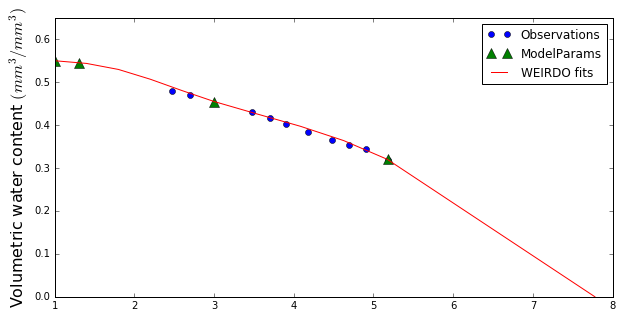

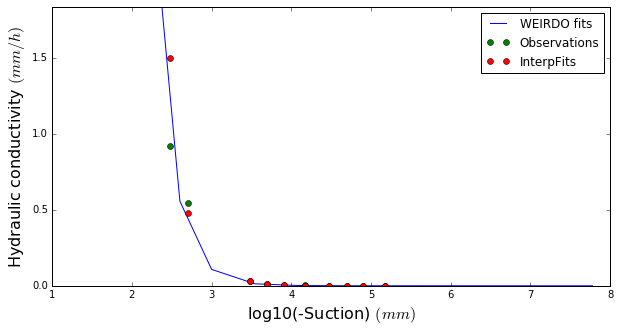

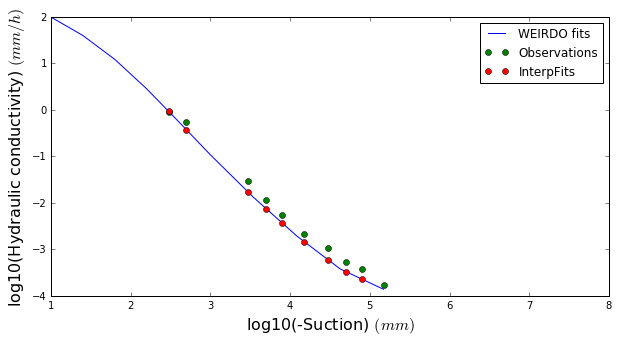

In [32]:
Set = '2360'
FitSAT = 0.55
FitDUL = 0.455
FitLL = 0.32
psibub = -20  #Should be a value between -10 and -600
Cflow = 6e-11
Xflow = 3.7

FitFrame = ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)
k = interp1d(FitFrame.ix[:,'PsiUpper'],FitFrame.ix[:,'Conductivity'])

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'Conductivity'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),k(-GraphData.ix[Set,'preshead']),'o',label = 'InterpFits')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
intLog10Cond = interpCond(GraphData.ix[Set,'preshead'],FitFrame.ix[:,'PsiUpper'],FitFrame.ix[:,'Conductivity'])
plt.plot(np.log10(GraphData.ix[Set,'preshead']),intLog10Cond,'o',label = 'InterpFits')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

## Fit k params

In [61]:
Fits = pd.DataFrame(index = map(str,GraphData.index.drop_duplicates().values),
                    columns = ['SAT','DUL','LL','psibub','Cflow','Xflow'])

In [65]:
#Function to fit hudraulic conductivity components and graph results.
def FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0):
    Obs_x = GraphData.ix[Set,'preshead'].values
    Obs_y = np.log10(GraphData.ix[Set,'conductivity'].values)

    bounds = (lower, upper)
    res = curve_fit(Condfun, Obs_x[Obs_x < 150000], Obs_y[Obs_x < 150000], bounds=bounds, p0 = p0)

    Cflow = res[0][0]
    Xflow = res[0][1]

    FitFrame = ConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

    Fits.ix[Set,'SAT'] = FitSAT
    Fits.ix[Set,'DUL'] = FitDUL
    Fits.ix[Set,'LL'] = FitLL
    Fits.ix[Set,'psibub'] = psibub
    Fits.ix[Set,'Cflow'] = Cflow
    Fits.ix[Set,'Xflow'] = Xflow

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
    plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
    plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
    plt.ylim(0,0.65)
    plt.text(1.5,.58,Set,fontsize=18)
    plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
    plt.legend()

    ymax = GraphData.ix[Set,'conductivity'].max() * 2
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'Conductivity'],label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
    plt.ylim(0,ymax)
    plt.legend()

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'Conductivity']),label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
    intLog10Cond = interpCond(GraphData.ix[Set,'preshead'],FitFrame.ix[:,'PsiUpper'],FitFrame.ix[:,'Conductivity'])
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),intLog10Cond,'o',label = 'InterpFitPoints')
    plt.text(2,1,'Cflow = ' + '%.4g' % Cflow + '\nXflow = ' + str(Xflow)[0:5], fontsize = 16)
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
    plt.xlim(1,8)
    plt.legend()

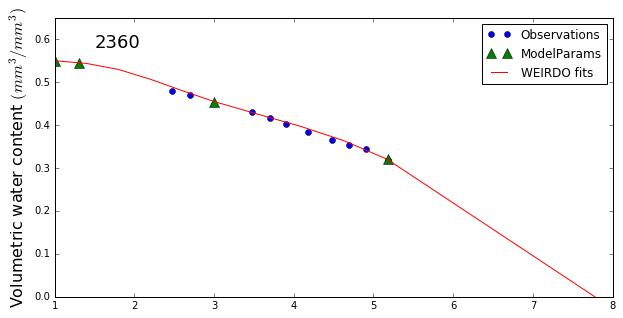

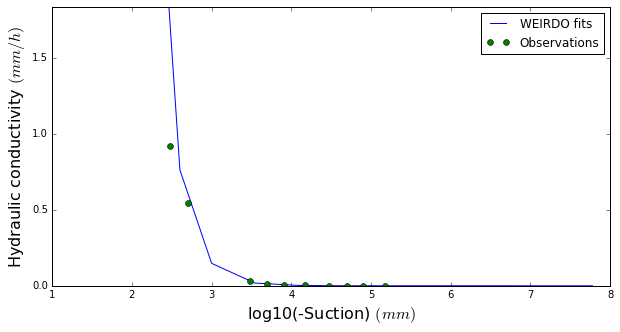

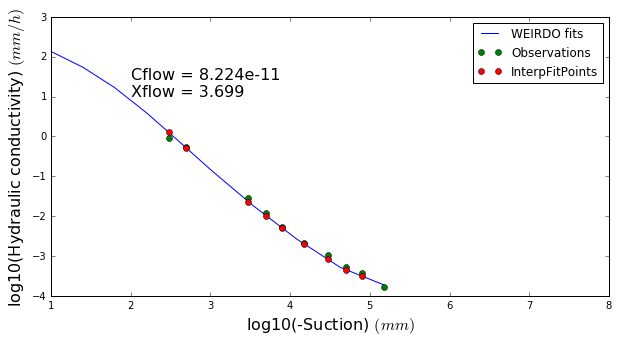

In [66]:
Set = '2360'
FitSAT = 0.55
FitDUL = 0.455
FitLL = 0.32
psibub = -20  #Should be a value between -10 and -600
lower = [0,0]
upper = [.001,10]
p0 = [6e-11,3.7]

FitNGraph(Set,FitSAT,FitDUL,FitLL,psibub,lower,upper,p0)

In [ ]:
def MakePlot(Set,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow):
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
    plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
    plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
    plt.ylim(0,0.65)
    plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
    plt.legend()

    FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

    ymax = GraphData.ix[Set,'conductivity'].max() * 2
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
    plt.ylim(0,ymax)
    plt.legend()

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
    plt.xlim(1,8)
    plt.legend()

In [ ]:
def MakePlotFitK(Set,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow):
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
    plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
    plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
    plt.ylim(0,0.65)
    plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
    plt.legend()

    FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

    ymax = GraphData.ix[Set,'conductivity'].max() * 2
    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
    plt.ylim(0,ymax)
    plt.legend()

    fig = plt.figure(figsize=(10,5))
    plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
    plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
    plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
    plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
    plt.xlim(1,8)
    plt.legend()

In [ ]:
Set = '2360'
FitSAT = 0.55
FitDUL = 0.455
FitLL = 0.32
psibub = -20  #Should be a value between -10 and -600
Cflow = 6e-11
Xflow = 3.7

MakePlot(Set,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

In [ ]:
#Implementation Note.  When DUL is close to SAT psibub needs to be a bigger negative 
# or else the spline exceeds the value of SAT at some points, giving odd volumes
Set = '2362'
FitSAT = 0.56
FitDUL = 0.55
FitLL = 0.42
psibub = -300  #Should be a value between -10 and -600
Cflow = 6e-11
Xflow = 3.7
MakePlot(Set,FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

In [ ]:
Set = '4592'
FitSAT = 0.45
FitDUL = 0.38
FitLL = 0.20
psibub = -100  #Should be a value between -10 and -600

Cflow = 6e-11
Xflow = 3.7

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4600'
FitSAT = 0.5
FitDUL = 0.44
FitLL = 0.27
psibub = -20  #Should be a value between -10 and -600

Cflow = 6e-11
Xflow = 3.7

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4602'
FitSAT = 0.45
FitDUL = 0.4
FitLL = 0.24
psibub = -200  #Should be a value between -10 and -600

Cflow = 6e-11
Xflow = 3.7

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4610'
FitSAT = 0.55
FitDUL = 0.42
FitLL = 0.25
psibub = -20  #Should be a value between -10 and -600

Cflow = 6e-11
Xflow = 3.7

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4611'
FitSAT = 0.58
FitDUL = 0.44
FitLL = 0.25
psibub = -20  #Should be a value between -10 and -600

Cflow = 6e-11
Xflow = 3.7

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4612'
FitSAT = 0.4
FitDUL = 0.35
FitLL = 0.20
psibub = -20  #Should be a value between -10 and -600

Cflow = 6e-11
Xflow = 3.7

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub,Cflow,Xflow)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4620'
FitSAT = 0.43
FitDUL = 0.36
FitLL = 0.22
psibub = -20  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4622'
FitSAT = 0.48
FitDUL = 0.38
FitLL = 0.24
psibub = -20  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4650'
FitSAT = 0.38
FitDUL = 0.1
FitLL = 0.02
psibub = -100  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4651'
FitSAT = 0.38
FitDUL = 0.1
FitLL = 0.06
psibub = -60  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4660'
FitSAT = 0.45
FitDUL = 0.15
FitLL = 0.06
psibub = -20  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4661'
FitSAT = 0.42
FitDUL = 0.09
FitLL = 0.04
psibub = -20  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4670'
FitSAT = 0.47
FitDUL = 0.37
FitLL = 0.08
psibub = -20  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4671'
FitSAT = 0.42
FitDUL = 0.37
FitLL = 0.08
psibub = -200  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4672'
FitSAT = 0.4
FitDUL = 0.37
FitLL = 0.19
psibub = -100  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4673'
FitSAT = 0.42
FitDUL = 0.38
FitLL = 0.15
psibub = -10  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4680'
FitSAT = 0.56
FitDUL = 0.53
FitLL = 0.32
psibub = -50  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = 100
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
Set = '4681'
FitSAT = 0.58
FitDUL = 0.56
FitLL = 0.35
psibub = -20  #Should be a value between -10 and -600

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'theta'],'o',label = 'Observations')
plt.plot(np.log10([10,-psibub,1000,150000]),[FitSAT,FitDUL+(FitSAT-FitDUL)*.95,FitDUL,FitLL],'^',markersize = 10,label = 'ModelParams')
plt.plot(np.log10(-BoundPSI),ThetaCurvemm5pt(FitSAT,FitDUL,FitLL,BoundPSI,psibub),label = 'WEIRDO fits')
plt.ylim(0,0.65)
plt.ylabel(r'Volumetric water content $(mm^3/mm^3)$',fontsize=16)
plt.legend()

FitFrame = MakeConductivityFrame(FitSAT,FitDUL,FitLL,psibub)

ymax = GraphData.ix[Set,'conductivity'].max() * 2
fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),FitFrame.ix[:,'CumCapil'],label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),GraphData.ix[Set,'conductivity'],'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'Hydraulic conductivity $(mm/h)$',fontsize=16)
plt.ylim(0,ymax)
plt.legend()

fig = plt.figure(figsize=(10,5))
plt.plot(np.log10(-FitFrame.ix[:,'PsiUpper']),np.log10(FitFrame.ix[:,'CumCapil']),label = 'WEIRDO fits')
plt.plot(np.log10(GraphData.ix[Set,'preshead']),np.log10(GraphData.ix[Set,'conductivity']),'o', label = 'Observations')
plt.xlabel(r'log10(-Suction) $(mm)$',fontsize=16)
plt.ylabel(r'log10(Hydraulic conductivity) $(mm/h)$',fontsize=16)
plt.xlim(1,8)
plt.legend()

In [ ]:
GraphData.index.drop_duplicates()

In [ ]:
np.log10(GraphData.ix[Set,'preshead'])

In [ ]:
GraphData.ix[Set,'conductivity']

In [ ]:
FullData.ix[:,'HydraulicConductivity'] = 0

# Calculate the hydraulic flow rate through a single pore compartment from pore size and number
def flowRate(Radius):
    Cflow = 3e-11
    Xflow = 4.0
    return Cflow * np.power(Radius,Xflow)
# FlowRate units = mm3/s
FullData.ix[:,'FlowRate'] =  [flowRate(FullData.ix[x,'PoreRadius']) for x in range(FullData.index.size)]
# VolumetricFlow units = mm3/s/m2
FullData.ix[:,'VolumetricFlow'] =  FullData.ix[:,'FlowRate'] * FullData.ix[:,'Number']
# Capillarity units = mm/h
FullData.ix[:,'Capillarity'] = FullData.ix[:,'VolumetricFlow']/1e6*3600
#Accumulate flow rates for current and smaller pores to calculate k at tension when this pore if full (i.e k curve)
def AccumCond(x):
    if x == 348:
        ret_val = FullData.ix[x,'Capillarity']
    else:
        if FullData.ix[x,'code'] != FullData.ix[x+1,'code']:
            ret_val = FullData.ix[x,'Capillarity']
        else:
            ret_val = FullData.ix[x,'Capillarity'] + FullData.ix[x+1,'HydraulicConductivity']
    return ret_val
for x in reversed(range(FullData.index.size)):
    FullData.ix[x,'HydraulicConductivity'] = AccumCond(x)
GraphData = FullData.set_index('code')

fig = plt.figure(figsize=(10,10))

for soil in GraphData.index:
    plt.plot(np.log10(GraphData.ix[soil,'conductivity']),np.log10(GraphData.ix[soil,'HydraulicConductivity']),'o-')
plt.ylabel('Predicted k log(cm/d)',fontsize=16)
plt.xlabel('Observed k log(cm/d)',fontsize=16)
plt.plot([-5,5],[-5,5],linewidth=7)

Cflow = plt.figure(figsize=(10,5))

In [ ]:
np.log10(.1)

## It appears that assuming Cflow increases with pore radius works OK??

In [ ]:
GraphData.ix['2360',:]#'conductivity']

In [ ]:
GraphData.columns